### Imports

In [4]:
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

### Establish database connection

In [5]:
conn = psycopg2.connect(user = "admin",
                        password = "admin",
                        host = "localhost",
                        port = "5432",
                        database = "fakenews_100k")
cursor = conn.cursor()

### Proof that we have a working database

In [6]:
cursor.execute("SELECT count(*) FROM article")
count = cursor.fetchone()[0]
print "Database contains {} scraped articles".format(count)

Database contains 100000 scraped articles


#### We can associate an article with a label

In [7]:
cursor.execute("SELECT article.article_id, typ.type_name FROM article INNER JOIN typ ON article.type_id = typ.type_id")
res = cursor.fetchmany(10)

In [8]:
print "{:10}\t {:12}".format("article_id", "type_name")
print "------------------------------"
for row in res:
    print "{:10}\t {:>12}".format(row[0], row[1])

article_id	 type_name   
------------------------------
         2	        rumor
         6	         hate
         7	         hate
         8	         hate
         9	         hate
        10	         hate
        11	   unreliable
        13	   unreliable
        14	   unreliable
        15	   unreliable


# Fake News Corpus

## Basic Statistics

### Label Distribution

In [9]:
cursor.execute("select typ.type_name, count(article.type_id) from article inner join typ on typ.type_id = article.type_id group by typ.type_name")
res = cursor.fetchall()

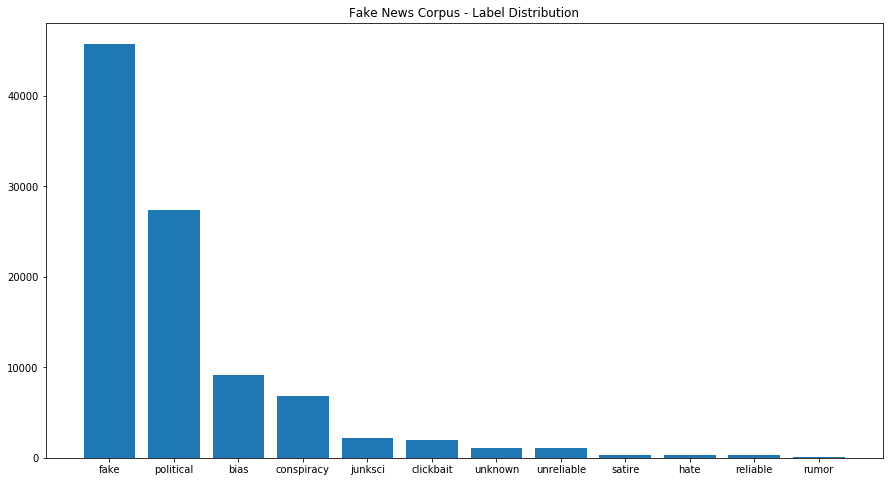

In [10]:
# Time to plot
res = sorted(res, key=lambda x: -x[1])

xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names)
plt.title("Fake News Corpus - Label Distribution")
plt.show()

### Author Distribution
I will perform this next exercise, under the assumption that all author names makes sense and are not poorly scraped

In [11]:
query = """
    SELECT WA.author_name, COUNT(WA.article_id)
    FROM (SELECT A.author_name, A.author_id, W.article_id
          FROM author as A, written_by as W
           WHERE A.author_id = W.author_id) as WA
    GROUP BY WA.author_name
    ORDER BY COUNT(WA.article_id) DESC
"""
cursor.execute(query)
res = cursor.fetchall()

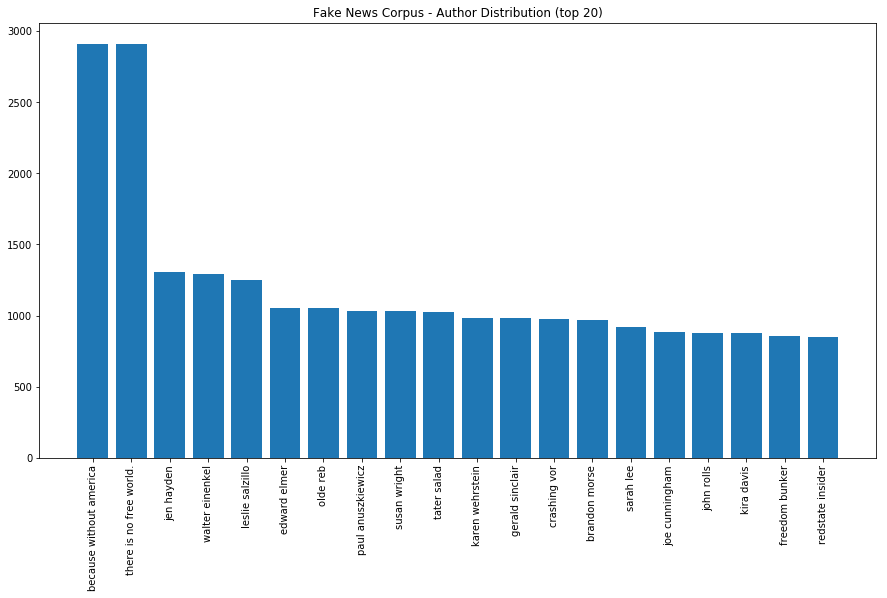

In [12]:
res = res[13:13+20] #first 13 are poorly scraped tags
xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names, rotation='vertical')
plt.title("Fake News Corpus - Author Distribution (top 20)")
plt.show()

### Who's contributing to fake news

In [13]:
# type_id = 2 is fake news
query = """
    SELECT FK.author_name, COUNT(FK.type_id)
    FROM (SELECT A.author_name, A.author_id, W.article_id, AR.type_id
          FROM author as A, written_by as W, article as AR
          WHERE A.author_id = W.author_id
              AND W.article_id = AR.article_id
              AND AR.type_id = 2) as FK
    GROUP BY FK.author_name
    ORDER BY COUNT(FK.type_id) DESC
"""
cursor.execute(query)
res = cursor.fetchmany(20)

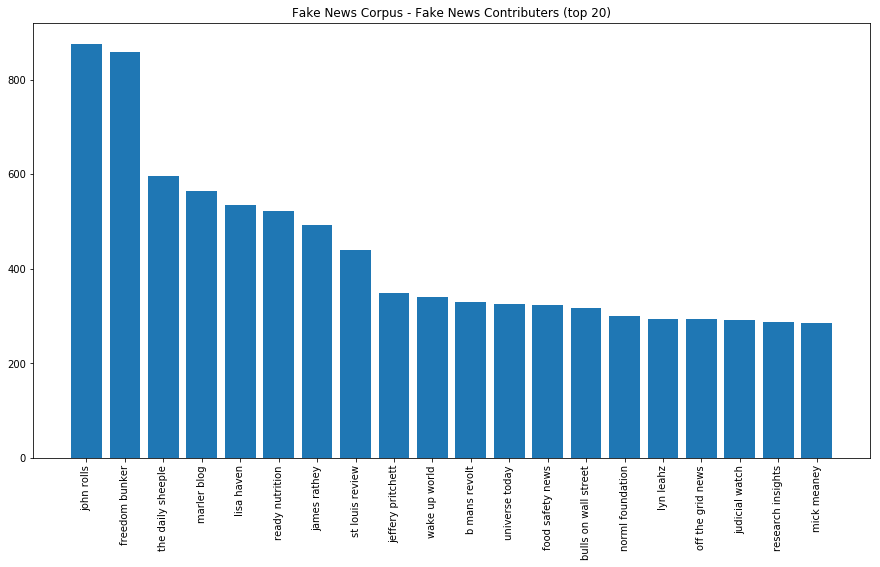

In [14]:
xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names, rotation='vertical')
plt.title("Fake News Corpus - Fake News Contributers (top 20)")
plt.show()

### Fake News Entity Cloud
Which entities are getting mentioned in fake news

In [94]:
query = """
    SELECT A.content
    FROM article as A
    WHERE A.type_id = 2
"""
cursor.execute(query)
res = cursor.fetchmany(20000)

In [95]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

text = res

def process_doc(text):
    doc = nlp(unicode(text[0]))
    # set - dont spam plz
    items = set([x.text.lower() for x in doc.ents if x.label_ == "ORG"])
    return items

rez = []
for t in text:
    rez += process_doc(t) # Fucking concat ;--)
    
freq = dict(Counter(rez))

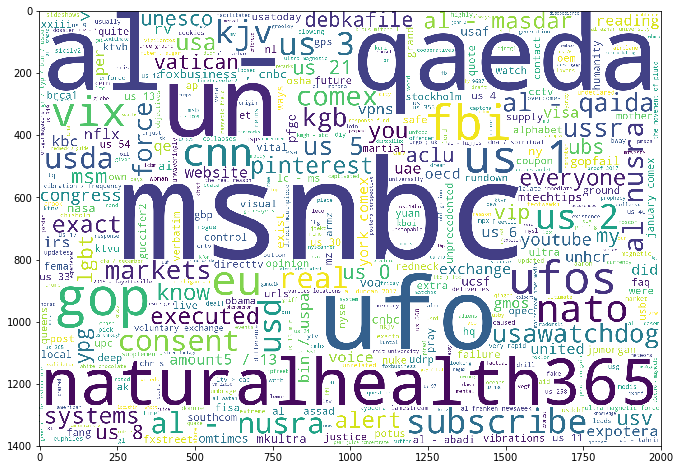

In [96]:
# Generate wordcloud
from wordcloud import WordCloud

wc = WordCloud(background_color="white",
               width=2000,
               height=1400, 
               max_words=500,
               relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(freq)

fig, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wc)

In [92]:
print len(freq.keys())

259
